# Classification

------------------------------------------------------------------------
This notebook deals with the study of the degradation within the first 30 cycles. Its purposes is to predict the quality of the cell after only 30 cycles, and conclude on how the cell will be degraded after.<br>
The code is developped under R programming language, and the final classification model will be saved at the end of the document for next experiments.

------------------------------------------------------------------------------------

##### Libraries

In [19]:
library(fda)
library(fda.usc)
library(funHDDC)
library(ggplot2)
library(MLmetrics)
library(reticulate)
pd = import("pandas")

##### Necessary ressources

In [57]:
X = pd$read_pickle("Prognostic-30.pkl")
Y = as.double(pd$read_pickle("Energy.pkl"))
V = pd$read_pickle("Voltage.pkl")

##### Definition of the threshold of degradation 

We calculated the value of energy for each cycle within discharge curves. Therfore, we decided to define the degradation as the average loss of energy from one cycle to another, normalized by the cycle life as follow :<br><br>
<center> $Degradation = \frac{1}{n}\sum_{i \leq 2} (energy_i-energy_{i-1})$ </center>

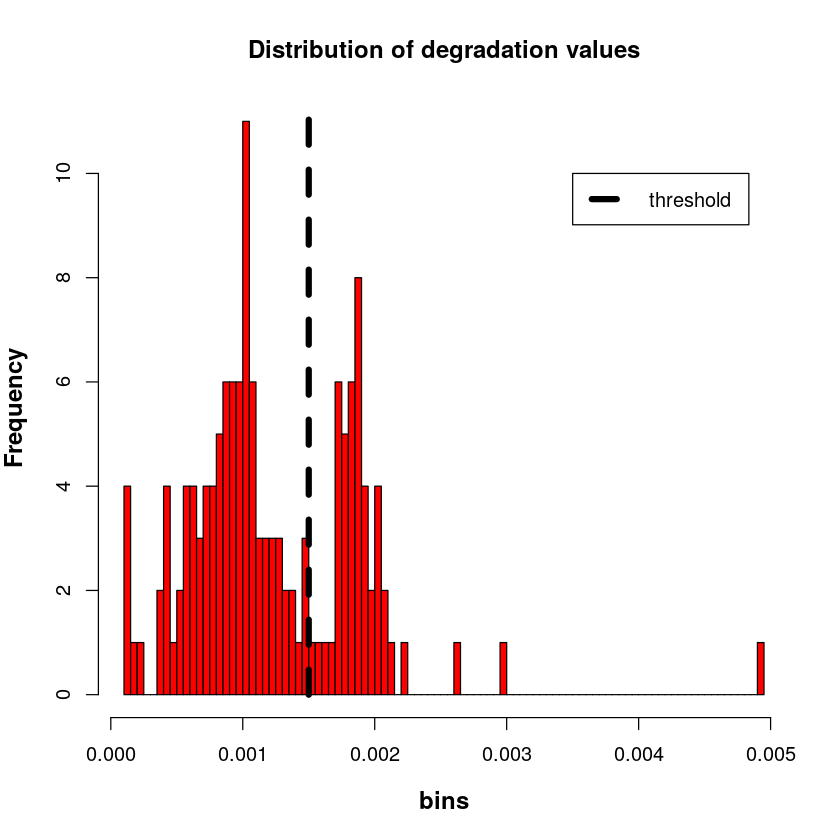

In [83]:
hist(Y, breaks=70, col='red', main="Distribution of degradation values",
    xlab="", ylab="")
lines(rep(mean(Y),10), seq(0,12, length.out = 10), lwd=5, lty="dashed")
legend(0.0035, 10, legend=c("threshold"),
       col=c("black"), lty="dashed", lwd=5)
mtext(side=1, line=3, "bins", col="black", font=2, cex=1.2)
mtext(side=2, line=3, "Frequency", col="black", font=2, cex=1.2)

According to the distribution of value, the threshold was empirically put at <strong>0.0012</strong> which is the mean value of the variable. It appear the threshold correctly separate the distribtion of cell degradation in two groups.

##### Definition of the functional input variable for the classification

The 30 cycles were used to calculated a specific functional input variable to train the classifier. Indeed, after empirical trials and errors, we decided to create the following function in terms of voltage :<br><br>
<center> $X(v) := \Delta (Q_{30}-Q_{2})(v)$ </center>
<br>
We display the function for all cells available in the dataset, colored by the threshold.

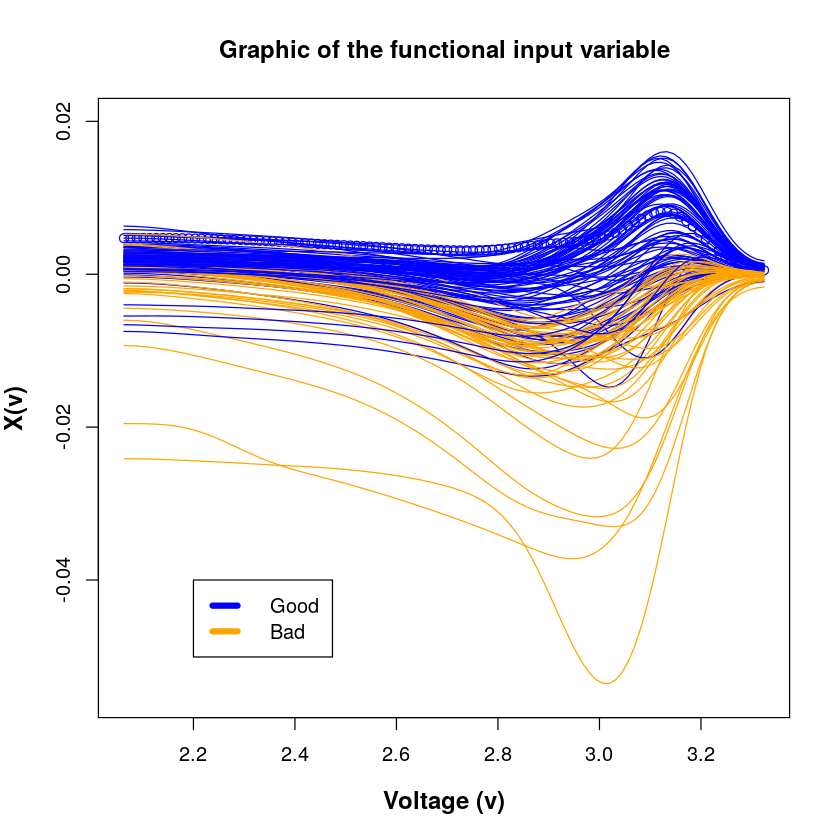

In [87]:
threshold = c()
for(i in 1:140){
    
    if (as.double(Y)[i] >= 0.0015) {
        threshold=c(threshold,1)
    } else {
        threshold=c(threshold,0)
    }   
}

if (threshold[1] >= mean(Y)){
    plot(V,as.double(X[1,]), ylim=c(-0.055,0.02), col="red", main="Graphic of the functional input variable",
    xlab="", ylab="")
} else{
    plot(V,as.double(X[1,]), ylim=c(-0.055,0.02), col="blue", main="Graphic of the functional input variable",
    xlab="", ylab="")
}
mtext(side=1, line=3, "Voltage (v)", col="black", font=2, cex=1.2)
mtext(side=2, line=3, "X(v)", col="black", font=2, cex=1.2)

for (i in 2:140){
    if (threshold[i] >= mean(Y)){
        lines(V,as.double(X[i,]), col="orange")
    } else{
        lines(V,as.double(X[i,]), col="blue")
    }
}

legend(2.2, -.04, legend=c("Good", "Bad"),
       col=c("blue", "orange"), lty="dashed", lwd=5)

#### Training of a functional logistic regression

A logistic regression was used in its functional form. The inputs where $(X_i(v))_{i \leq p}$ with $p$ the total number of cells, and the output is a binary features defined above.

In [104]:
ind = sample(1:140, size=140*0.8)
xtrain=X[ind,]
xtest=X[-ind,]
ytrain=threshold[ind]
ytest=threshold[-ind]

dataf = data.frame(ytrain)
colnames(dataf) = "glearn"
dat=list("df"=dataf,
         "x"=fdata(xtrain, argvals = seq(min(V), max(V), length.out = 100), rangeval = c(min(V), max(V))))
mod=classif.glm(glearn~x, data = dat)

In [105]:
pred=predict(mod,list("x"=fdata(xtest, argvals = seq(min(V), max(V), length.out = 100),
                               rangeval = c(min(V), max(V)))))

print(table(ytest,pred))

print(sum(pred==ytest)/28)
print(F1_Score(ytest,pred))

     pred
ytest  0  1
    0 16  3
    1  0  9

In [107]:
save(mod, file = "Classifier.rda")

[1]  28 100